In [1]:
import random

import tensorflow as tf
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
train_x = mnist.train.images
train_y = mnist.train.labels

train_x = np.asarray(train_x)
train_y = np.asarray(train_y)

idx = np.argsort(train_y)
train_x = train_x[idx]
train_y = train_y[idx]

print(train_x.shape)
print(train_y.shape)

(55000, 784)
(55000,)


In [4]:
cnt = -1
train_x_per_class = {}
for i in range(train_x.shape[0]):
    if cnt == train_y[i]:
        train_x_per_class[cnt].append(train_x[i])
    else:
        cnt += 1
        train_x_per_class[cnt] = []

for i in range(len(train_x_per_class)):
    print(len(train_x_per_class[i]))

5443
6178
5469
5637
5306
4986
5416
5714
5388
5453


In [5]:
total_epochs = 1000
batch_size = 100
learning_rate = 0.001
random_size = 100
image_size = 28*28
z_dim = 120

In [6]:
init = tf.random_normal_initializer(mean=0, stddev=0.15)

def encoder(x, reuse=False):
    l = [image_size, 50, 30, z_dim]
    with tf.variable_scope(name_or_scope="mnist_encoder", reuse=reuse) as scope:
        out1 = tf.layers.dense(x, l[1], activation=tf.nn.relu)
        out2 = tf.layers.dense(out1, l[2], activation=tf.nn.relu)
        output = tf.layers.dense(out2, l[3], activation=tf.nn.sigmoid)
        return output

def decoder(z, reuse=False):
    l = [z_dim, 30, 50, image_size]
    with tf.variable_scope(name_or_scope="mnist_decoder", reuse=reuse) as scope:
        out1 = tf.layers.dense(z, l[1], activation=tf.nn.relu)
        out2 = tf.layers.dense(out1, l[2], activation=tf.nn.relu)
        output = tf.layers.dense(out2, l[3], activation=tf.nn.sigmoid)
        return output

In [7]:
def random_z():
    return np.random.normal(size=[1, z_dim])

def dist(x1, x2):
    d = 0
    for i in range(x1.shape[0]):
        for j in range(x2.shape[0]):
            l = x1[i] - x2[j]
            d += np.sqrt(np.dot(l, l))
    return d / (x1.shape[0] * x2.shape[0])

In [8]:
g = tf.Graph()

with g.as_default():
    X1 = tf.placeholder(tf.float32, [None, image_size])
    X2 = tf.placeholder(tf.float32, [None, image_size])
    Z = tf.placeholder(tf.float32, [1, z_dim])

    enc1 = encoder(X1)
    dec1 = decoder(enc1)

    enc2 = encoder(X2, True)
    dec2 = decoder(enc2, True)

    loss1 = tf.reduce_mean(tf.square(X1 - dec1))
    loss2 = tf.reduce_mean(tf.square(X2 - dec2))
    avg_loss = -100 * tf.square(tf.reduce_mean(X1) - tf.reduce_mean(X2))
    var_loss1 = tf.reduce_mean(tf.reduce_mean(tf.square(X1)) - tf.square(tf.reduce_mean(X1)))
    var_loss2 = tf.reduce_mean(tf.reduce_mean(tf.square(X2)) - tf.square(tf.reduce_mean(X2)))
    loss = loss1 + loss2 + avg_loss + var_loss1 + var_loss2

    t_vars = tf.trainable_variables()
    e_vars = [var for var in t_vars if "encoder" in var.name]
    d_vars = [var for var in t_vars if "decoder" in var.name]
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train = optimizer.minimize(loss, var_list=e_vars + d_vars)

=== Epoch  0  ===
loss:  0.28724423


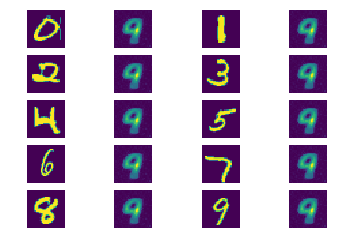

=== Distances ===
0 0 0.2657070673167706
0 1 0.8233808053039015
0 2 0.35948384589888155
0 3 0.34451888617128135
0 4 0.3928359381146729
0 5 0.40362931771762667
0 6 0.375767898163572
0 7 0.37838329903930423
0 8 0.335864809852466
0 9 0.3586526844158769

1 1 0.48352592969164254
1 2 0.7353935220643878
1 3 0.707932277007401
1 4 0.6305840328373015
1 5 0.6948594172216952
1 6 0.6542438019774854
1 7 0.6428446568518877
1 8 0.7501721733670682
1 9 0.7104339805789291

2 2 0.3486078415043652
2 3 0.3373560825627297
2 4 0.38481345176808535
2 5 0.4112805693522096
2 6 0.36911940233372154
2 7 0.3799201801329851
2 8 0.37276508325897156
2 9 0.39451696942821146

3 3 0.3071596173346043
3 4 0.35365720951631663
3 5 0.3854688680913299
3 6 0.33887830699793997
3 7 0.3469286245673895
3 8 0.3374766856111586
3 9 0.35717022712416946

4 4 0.3340410839177668
4 5 0.3968446239829063
4 6 0.34573349269256
4 7 0.33135343489013613
4 8 0.3619585646741092
4 9 0.34740568345971407

5 5 0.43155444353073835
5 6 0.3936351573068649
5

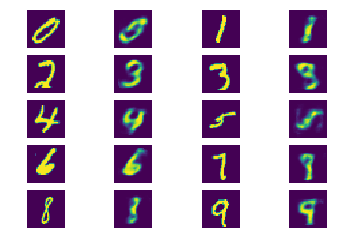

=== Epoch  100  ===
loss:  0.16973414


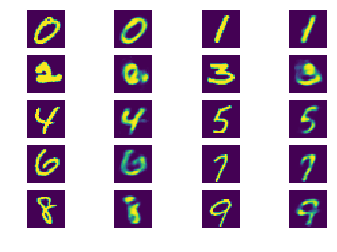

=== Epoch  150  ===
loss:  0.19621132


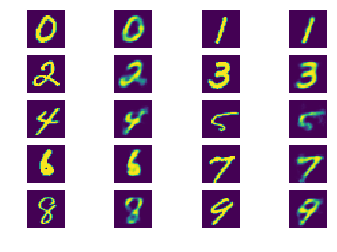

=== Epoch  200  ===
loss:  0.19305605


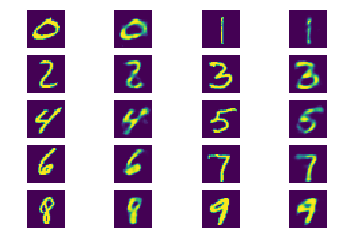

=== Distances ===
0 0 2.728768999004364
0 1 4.2232463052272795
0 2 3.512295854485035
0 3 3.4671123354434967
0 4 3.8606619965553284
0 5 3.2952872144699095
0 6 3.595533152163029
0 7 3.7618702330350877
0 8 3.5158979170680045
0 9 3.69210606405735

1 1 2.638740475356579
1 2 3.875288462114334
1 3 3.8423432797431945
1 4 3.8488575494408606
1 5 3.840861441445351
1 6 3.827631405448914
1 7 4.014846620965004
1 8 3.595533655667305
1 9 3.918726846575737

2 2 3.031806520652771
2 3 3.3754519938588143
2 4 3.6704699786067008
2 5 3.487536473083496
2 6 3.405125881576538
2 7 3.838852150070667
2 8 3.3511732547044755
2 9 3.7023329519987107

3 3 2.883703113877773
3 4 3.716318981158733
3 5 3.229559194135666
3 6 3.6461736193299292
3 7 3.8361867624163626
3 8 3.233669082045555
3 9 3.674339509308338

4 4 2.9912311077952385
4 5 3.604346992599964
4 6 3.6510542816281317
4 7 3.5390577104091645
4 8 3.5062969699978828
4 9 3.153931077206135

5 5 3.0049282779335975
5 6 3.4875004898905755
5 7 3.7922771574497225
5 8 3.22131

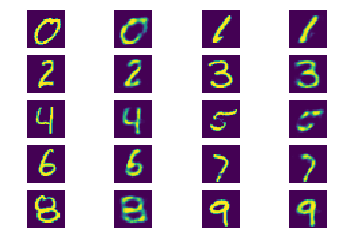

=== Epoch  300  ===
loss:  -0.008372173


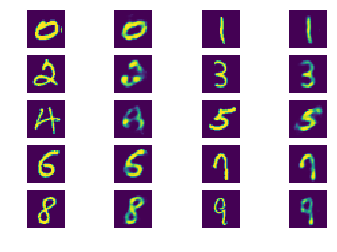

=== Epoch  350  ===
loss:  0.18654415


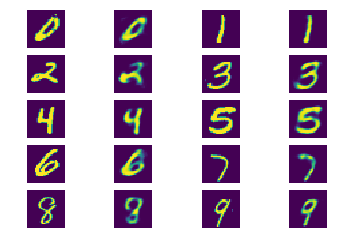

=== Epoch  400  ===
loss:  0.23527832


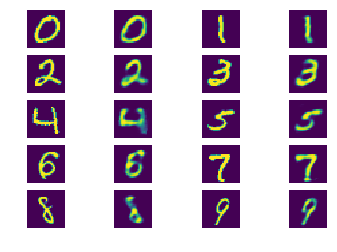

=== Distances ===
0 0 2.4523414288163186
0 1 3.8577392412900924
0 2 3.201641419816017
0 3 3.092908750772476
0 4 3.3515762062191965
0 5 2.9954579085826873
0 6 3.239901922369003
0 7 3.3187750889897347
0 8 3.1413314667224883
0 9 3.2507038539648057

1 1 2.3820572178542614
1 2 3.434902263081074
1 3 3.4250239029288294
1 4 3.46072677192688
1 5 3.494556996333599
1 6 3.509308244740963
1 7 3.5815006019711495
1 8 3.2054172580718996
1 9 3.4981053022146225

2 2 2.7505322924971582
2 3 3.022796270084381
2 4 3.24480026113987
2 5 3.1852183597922323
2 6 3.1255506739258765
2 7 3.4391000387072563
2 8 3.0086419219493865
2 9 3.31116012891531

3 3 2.5505787469148635
3 4 3.19113897908926
3 5 2.892825583565235
3 6 3.280770075571537
3 7 3.270623677420616
3 8 2.860451573896408
3 9 3.15702286452055

4 4 2.6724360743999482
4 5 3.130913983917236
4 6 3.189798875927925
4 7 3.123296213400364
4 8 3.0089918867111205
4 9 2.796983677840233

5 5 2.730694238245487
5 6 3.165897636175156
5 7 3.3114330058574675
5 8 2.874493865

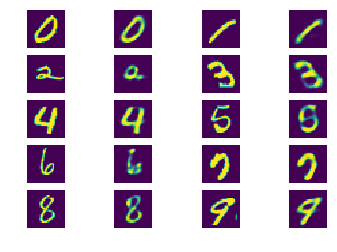

=== Epoch  500  ===
loss:  0.22417313


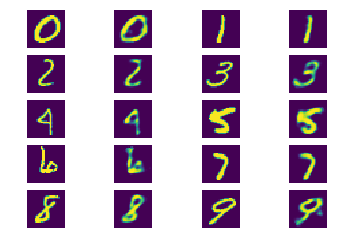

=== Epoch  550  ===
loss:  0.1765489


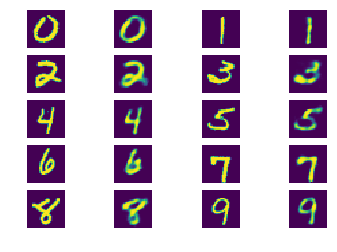

=== Epoch  600  ===
loss:  0.18159415


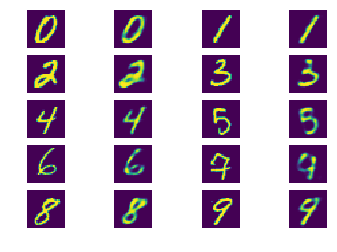

=== Distances ===
0 0 2.2675185511112215
0 1 3.586880604326725
0 2 3.037832636427879
0 3 2.93401495898962
0 4 3.342031028199196
0 5 2.7984904844641685
0 6 3.0916681613087653
0 7 3.234155850327015
0 8 2.965179334640503
0 9 3.188079059648514

1 1 2.3337328857839106
1 2 3.216485553276539
1 3 3.196994572389126
1 4 3.253231866621971
1 5 3.248781524980068
1 6 3.265650650715828
1 7 3.3276658856987953
1 8 2.9704777927041053
1 9 3.2344105402112007

2 2 2.675042451238632
2 3 2.9108661967754363
2 4 3.310469590783119
2 5 3.050129517054558
2 6 3.034792027640343
2 7 3.3901823508262634
2 8 2.9192825616836546
2 9 3.3100102524876593

3 3 2.4552324586749075
3 4 3.2469138301610947
3 5 2.7965726132154463
3 6 3.196486693894863
3 7 3.182223585534096
3 8 2.7293285688638687
3 9 3.1310876174092295

4 4 2.685495980143547
4 5 3.1602367840528487
4 6 3.2125158639669418
4 7 3.127029073667526
4 8 3.0129445292711257
4 9 2.8005912257015706

5 5 2.6306959985494616
5 6 3.0530950927972795
5 7 3.185436903858185
5 8 2.7234

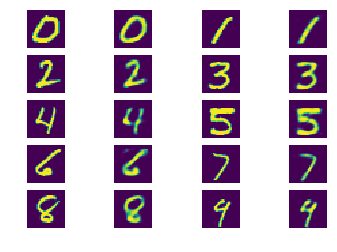

=== Epoch  700  ===
loss:  0.02792105


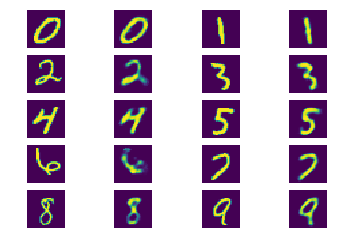

=== Epoch  750  ===
loss:  0.15453607


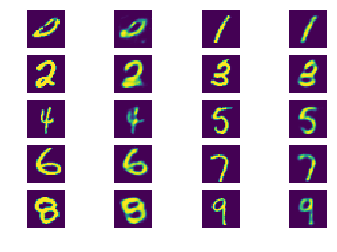

=== Epoch  800  ===
loss:  0.117432125


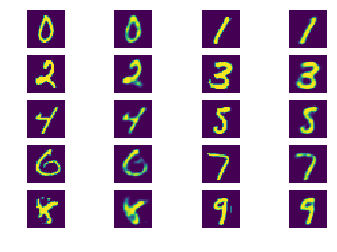

=== Distances ===
0 0 2.245429134070873
0 1 3.3316046409606934
0 2 2.89051413487196
0 3 2.7903798827171324
0 4 3.2161574491858484
0 5 2.730407587969303
0 6 2.9222713133335114
0 7 3.150761752021313
0 8 2.8968611217975617
0 9 3.0949189341664316

1 1 2.025638135546446
1 2 2.917154426264763
1 3 2.8984543347239495
1 4 2.961625403904915
1 5 2.9241985097050667
1 6 2.9583091343402863
1 7 2.964724035704136
1 8 2.598553405892849
1 9 2.8855555693387984

2 2 2.481080941784382
2 3 2.719096144413948
2 4 3.06794312928915
2 5 2.832813360238075
2 6 2.7689315299391746
2 7 3.1651696759819985
2 8 2.734314478266239
2 9 3.068493642556667

3 3 2.287655056524277
3 4 3.055504668593407
3 5 2.593422127556801
3 6 2.9504804711699486
3 7 2.9975624505758285
3 8 2.5644999477386476
3 9 2.934772699582577

4 4 2.520109955346584
4 5 2.989304287338257
4 6 2.945845370864868
4 7 2.931885837006569
4 8 2.845388268971443
4 9 2.633895751106739

5 5 2.465015962612629
5 6 2.8120261736392975
5 7 3.030459982717037
5 8 2.56256809314

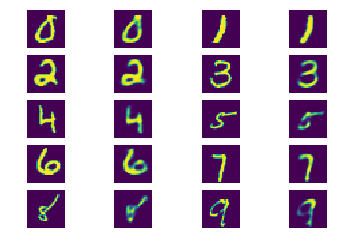

=== Epoch  900  ===
loss:  0.20586225


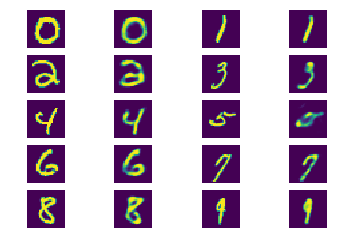

=== Epoch  950  ===
loss:  0.18506716


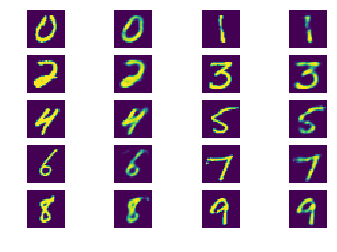

In [9]:
with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())

    for epoch in range(total_epochs):
        class1 = random.randint(0, 9)
        class2 = random.randint(0, 9)
        while class1 == class2:
            class1 = random.randint(0, 9)
            class2 = random.randint(0, 9)

        data1 = np.copy(train_x_per_class[class1])
        data2 = np.copy(train_x_per_class[class2])
        np.random.shuffle(data1)
        np.random.shuffle(data2)

        total_batchs = int(min(len(data1), len(data2)) / batch_size)
        for batch in range(total_batchs):
            batch_x1 = data1[(batch * batch_size):((batch + 1) * batch_size)]
            batch_x2 = data2[(batch * batch_size):((batch + 1) * batch_size)]

            sess.run(train, feed_dict={X1: batch_x1, X2: batch_x2})

        if epoch % 50 == 0:
            print("=== Epoch ", epoch, " ===")
            loss_r = sess.run(loss, feed_dict={X1: batch_x1, X2: batch_x2})
            print("loss: ", loss_r)
            
            x_list = []
            for cls in range(10):
                candidate = train_x_per_class[cls]
                x_list.append(candidate[random.randint(0, len(candidate) - 1)])
            x_list = np.asarray(x_list)
            
            gen_list = sess.run(dec1, feed_dict={X1: x_list})
            origimg = x_list.reshape([-1, 28, 28])
            genimg = gen_list.reshape([-1, 28, 28])
            
            _, axes = plt.subplots(5, 4)
            for cls in range(10):
                axes[cls // 2, (cls % 2) * 2 + 0].imshow(origimg[cls])
                axes[cls // 2, (cls % 2) * 2 + 0].axis('off')
                axes[cls // 2, (cls % 2) * 2 + 1].imshow(genimg[cls])
                axes[cls // 2, (cls % 2) * 2 + 1].axis('off')
            plt.show()

        if epoch % 200 == 0:
            print('=== Distances ===')
            for i in range(10):
                for j in range(i, 10):
                    gen1, gen2 = sess.run(
                        [enc1, enc2],
                        feed_dict={X1: train_x_per_class[i][0:100], X2: train_x_per_class[j][0:100]}
                    )
                    print(i, j, dist(gen1, gen2))
                print()